In [3]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
from poppy.poppy_core import PlaneType

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

from prop_models import compact, agpm
import misc_funs as misc
reload(compact)

wavelength_c = 750e-9*u.m

reload(agpm)
vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm, gray_pixel=False)


In [5]:
reload(compact)
c = compact.CORO(npix=128, oversample=16, npsf=100)

INFO:poppy:Loaded influence function from inf.fits for DM
INFO:poppy:Initialized OpticalSystem: unnamed system
INFO:poppy:Added pupil plane: Circle, radius=5.1 mm
INFO:poppy:Added pupil plane: Retrieved WFE Place-holder
INFO:poppy:Added pupil plane: DM
INFO:poppy:Added pupil plane: Apodizer Place-holder
INFO:poppy:Added image plane: FPM Place-holder
INFO:poppy:Added pupil plane: Lyot Stop Place-holder
INFO:poppy:Added detector with pixelscale=57.77725665184773 and oversampling=16: Detector


INFO:poppy:Initialized OpticalSystem: unnamed system
INFO:poppy:Added pupil plane: Circle, radius=5.1 mm
INFO:poppy:Added pupil plane: Retrieved WFE Place-holder
INFO:poppy:Added pupil plane: DM
INFO:poppy:Added pupil plane: Apodizer Place-holder
INFO:poppy:Added image plane: FPM Place-holder
INFO:poppy:Added pupil plane: Lyot Stop
INFO:poppy:Added detector with pixelscale=57.77725665184773 and oversampling=16: Detector
INFO:poppy:Calculating PSF with 1 wavelengths
DEBUG:poppy:Already loaded wisdom prior to this calculation, not reloading.
INFO:poppy: Propagating wavelength = 1e-06 m
INFO:poppy:Using user-defined Wavefront() for the input wavefront of the OpticalSystem().
DEBUG:poppy:Input wavefront has wavelength=1e-06 m, npix=128, diam=0.0102, pixel scale=7.97e-05 meters/pixel
DEBUG:poppy:  Wavefront and optic Circle, radius=5.1 mm already at same plane type, no propagation needed.
DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: Circle, radius=5.1 mm
DEBUG:poppy:normalizing at

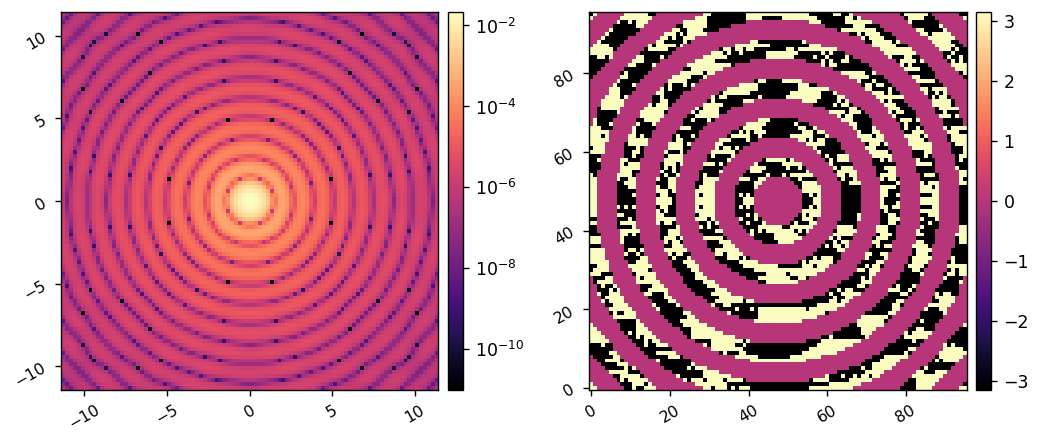

In [7]:
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm / c.pupil_lyot_ratio, gray_pixel=False)

c.LYOT = lyot_stop

psf = c.calc_psf()
misc.imshow2(np.abs(psf)**2, np.angle(psf),
             pxscl1=c.psf_pixelscale_lamD, lognorm1=True)


DEBUG:poppy:Skipping oversampling, oversample < 1 or already padded 


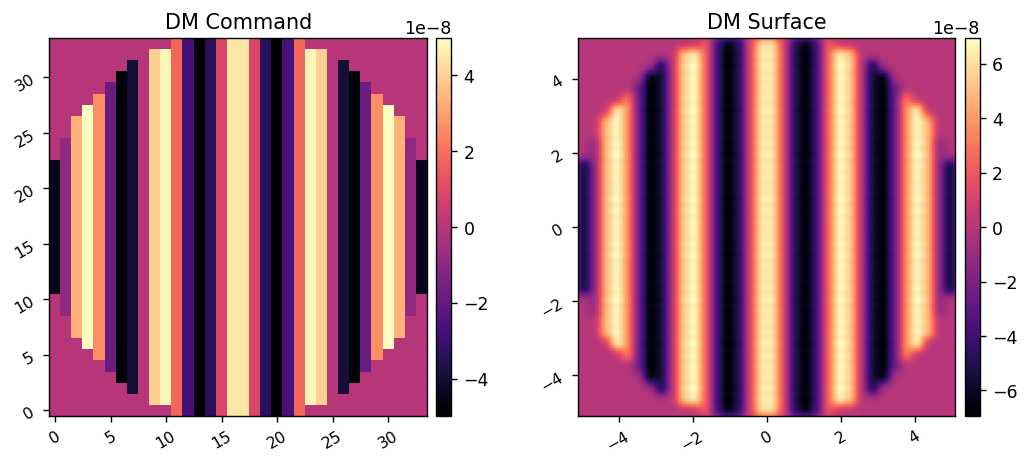

INFO:poppy:Initialized OpticalSystem: unnamed system
INFO:poppy:Added pupil plane: Circle, radius=5.1 mm
INFO:poppy:Added pupil plane: Retrieved WFE Place-holder
INFO:poppy:Added pupil plane: DM
INFO:poppy:Added pupil plane: Apodizer Place-holder
INFO:poppy:Added image plane: FPM Place-holder
INFO:poppy:Added pupil plane: Lyot Stop
INFO:poppy:Added detector with pixelscale=57.77725665184773 and oversampling=16: Detector
INFO:poppy:Calculating PSF with 1 wavelengths
DEBUG:poppy:Already loaded wisdom prior to this calculation, not reloading.
INFO:poppy: Propagating wavelength = 1e-06 m
INFO:poppy:Using user-defined Wavefront() for the input wavefront of the OpticalSystem().
DEBUG:poppy:Input wavefront has wavelength=1e-06 m, npix=128, diam=0.0102, pixel scale=7.97e-05 meters/pixel
DEBUG:poppy:  Wavefront and optic Circle, radius=5.1 mm already at same plane type, no propagation needed.
DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: Circle, radius=5.1 mm
DEBUG:poppy:normalizing at

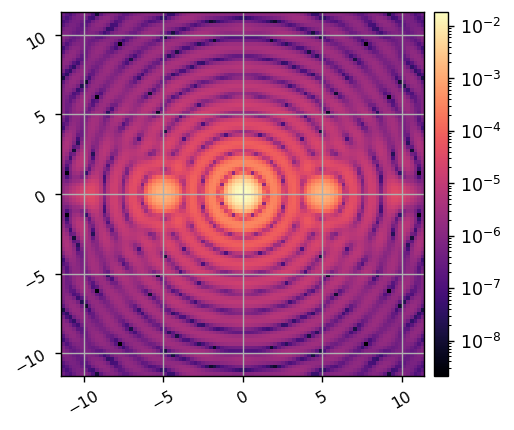

DEBUG:poppy:Skipping oversampling, oversample < 1 or already padded 


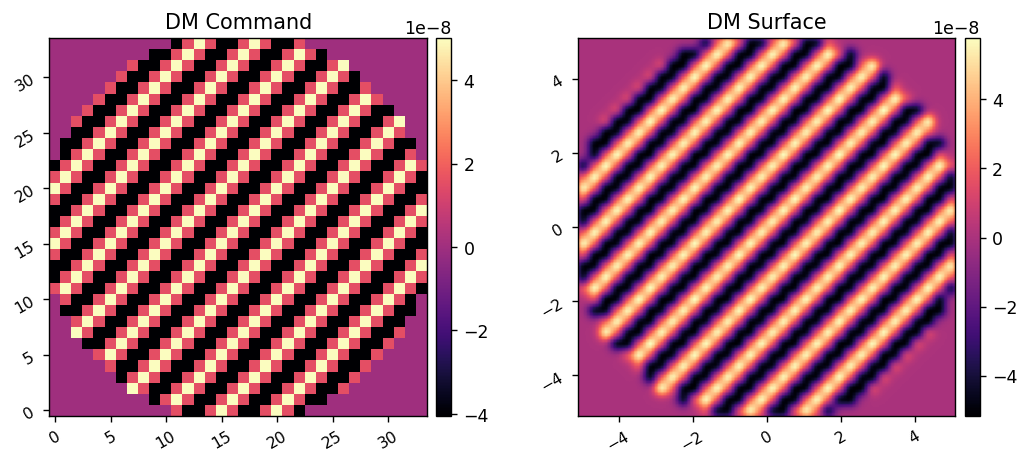

INFO:poppy:Initialized OpticalSystem: unnamed system
INFO:poppy:Added pupil plane: Circle, radius=5.1 mm
INFO:poppy:Added pupil plane: Retrieved WFE Place-holder
INFO:poppy:Added pupil plane: DM
INFO:poppy:Added pupil plane: Apodizer Place-holder
INFO:poppy:Added image plane: FPM Place-holder
INFO:poppy:Added pupil plane: Lyot Stop
INFO:poppy:Added detector with pixelscale=57.77725665184773 and oversampling=16: Detector
INFO:poppy:Calculating PSF with 1 wavelengths
DEBUG:poppy:Already loaded wisdom prior to this calculation, not reloading.
INFO:poppy: Propagating wavelength = 1e-06 m
INFO:poppy:Using user-defined Wavefront() for the input wavefront of the OpticalSystem().
DEBUG:poppy:Input wavefront has wavelength=1e-06 m, npix=128, diam=0.0102, pixel scale=7.97e-05 meters/pixel
DEBUG:poppy:  Wavefront and optic Circle, radius=5.1 mm already at same plane type, no propagation needed.
DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: Circle, radius=5.1 mm
DEBUG:poppy:normalizing at

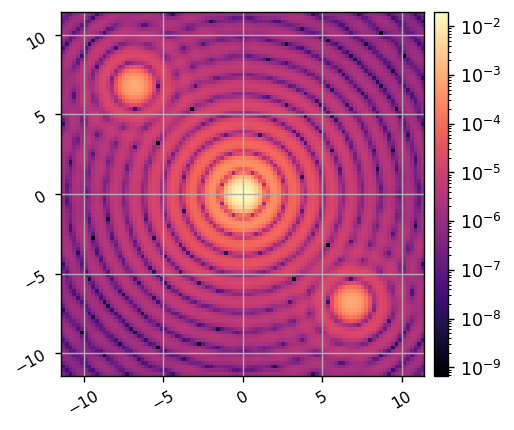

In [8]:
Nact = c.Nact

xpp = np.linspace(-c.Nact/2, c.Nact/2-1, c.Nact) + 1/2
ppx, ppy = np.meshgrid(xpp,xpp)

separation = 5

amp = 5e-8
com_1 = amp*np.cos(2*np.pi*ppx*separation/Nact)*c.dm_mask
com_2 = amp*np.cos(2*np.pi*(ppx - ppy)/separation)*c.dm_mask

c.set_dm(com_1)
c.show_dm()
im1 = c.snap()
misc.imshow1(im1, pxscl=c.psf_pixelscale_lamD, lognorm=True, grid=True)

c.set_dm(com_2)
c.show_dm()
im2 = c.snap()
misc.imshow1(im2, pxscl=c.psf_pixelscale_lamD, lognorm=True, grid=True)

c.reset_dm()

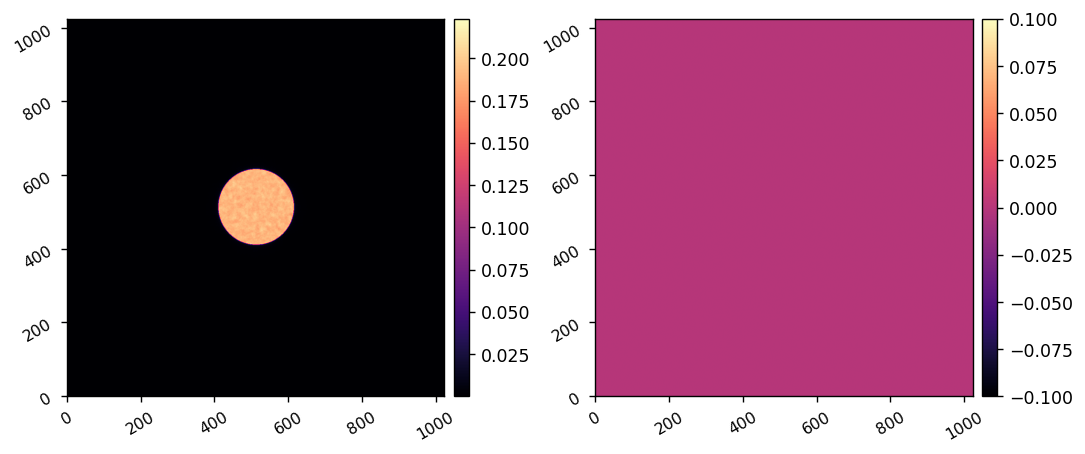

In [32]:
wfe = fits.getdata('pupil-data/retrieved_wfe.fits')
wfe_pxscl = fits.getheader('pupil-data/retrieved_wfe.fits')['PIXELSCL']

wfe = poppy.ArrayOpticalElement(transmission=wfe[0]/5, 
#                                 opd=wfe[1]*wavelength_c.to_value(u.m)/(2*np.pi),
                               )
misc.imshow2(wfe.amplitude, wfe.opd)

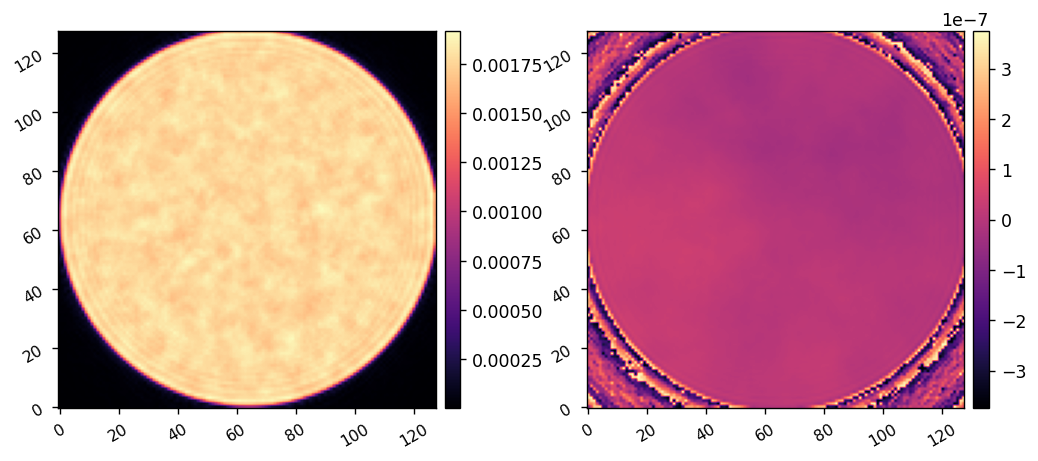

In [13]:
wfe = fits.getdata('pupil-data/post_fpm_pupil_wfe.fits')
wfe_pxscl = fits.getheader('pupil-data/post_fpm_pupil_wfe.fits')['PIXELSCL'] * u.m/u.pix

wfe = poppy.ArrayOpticalElement(transmission=wfe[0]/5, 
                                opd=wfe[1]*wavelength_c.to_value(u.m)/(2*np.pi),
                                pixelscale=wfe_pxscl,
                               )
misc.imshow2(wfe.amplitude, wfe.opd)

Propagating wavelength 750.000 nm.
INFO:poppy:Initialized OpticalSystem: unnamed system
INFO:poppy:Added pupil plane: Circle, radius=5.1 mm
INFO:poppy:Added pupil plane: unnamed optic
INFO:poppy:Added pupil plane: DM
INFO:poppy:Added pupil plane: Apodizer Place-holder
INFO:poppy:Added image plane: FPM Place-holder
INFO:poppy:Added pupil plane: Lyot Stop
INFO:poppy:Added detector with pixelscale=57.77725665184773 and oversampling=16: Detector
INFO:poppy:Calculating PSF with 1 wavelengths
INFO:poppy:User requested saving intermediate wavefronts in call to poppy.calc_psf
DEBUG:poppy:Already loaded wisdom prior to this calculation, not reloading.
INFO:poppy: Propagating wavelength = 1e-06 m
INFO:poppy:Using user-defined Wavefront() for the input wavefront of the OpticalSystem().
DEBUG:poppy:Input wavefront has wavelength=1e-06 m, npix=128, diam=0.0102, pixel scale=7.97e-05 meters/pixel
DEBUG:poppy:  Wavefront and optic Circle, radius=5.1 mm already at same plane type, no propagation needed

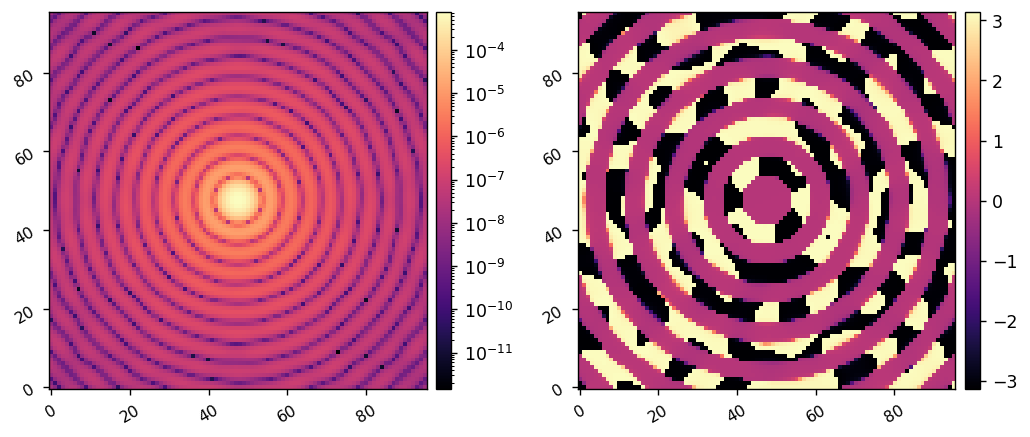

In [35]:
c.reset_dm()
# c.set_dm(com_2)

c.RETRIEVED = None
c.RETRIEVED = wfe

# c.FPM = None
# c.FPM = vortex

c.LYOT = None
c.LYOT = lyot_stop

wfs = c.calc_wfs()

misc.imshow2(wfs[-1].intensity, wfs[-1].phase, lognorm1=True)

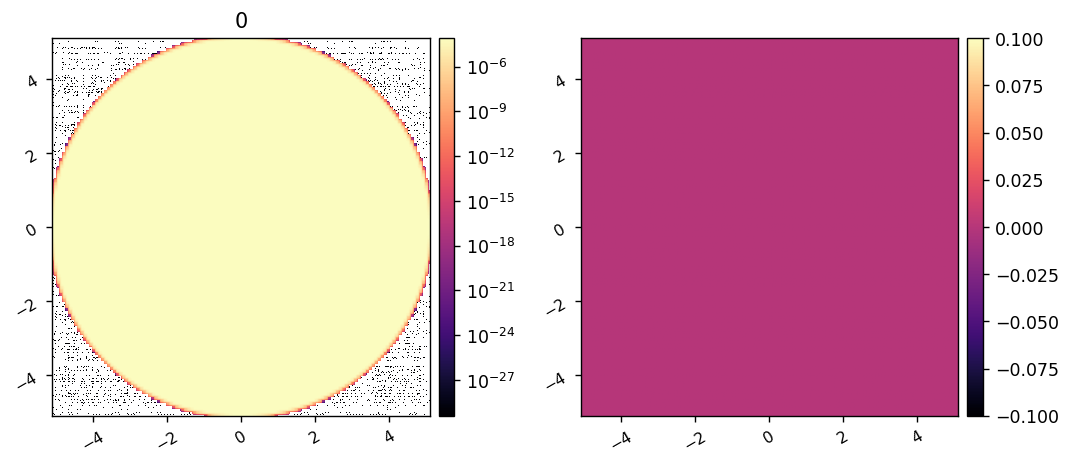

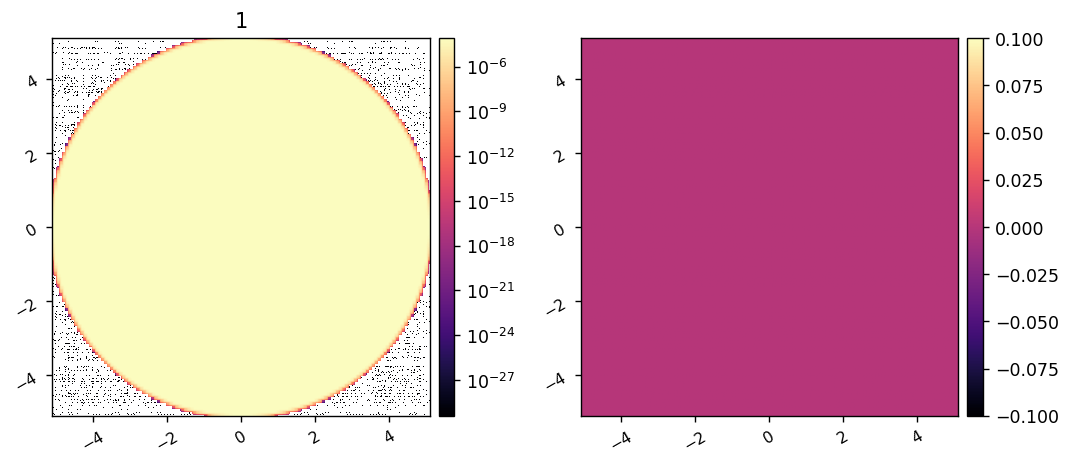

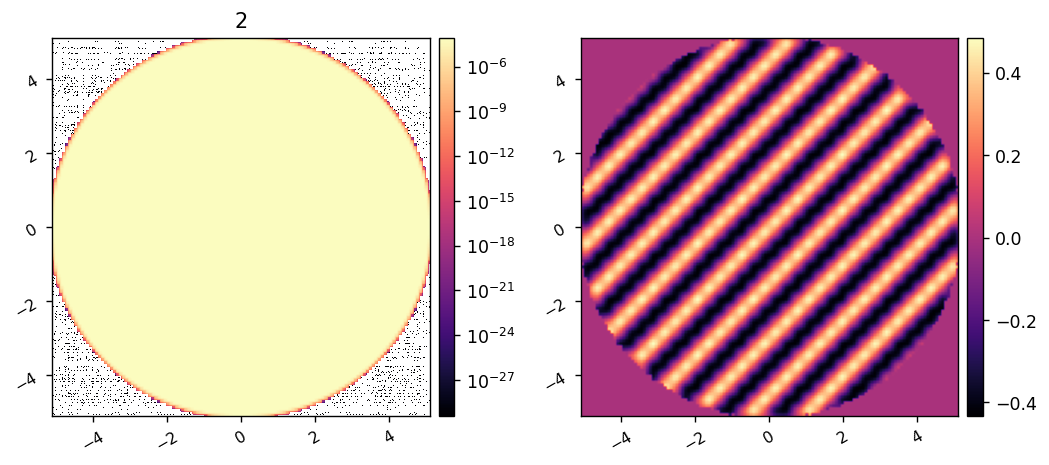

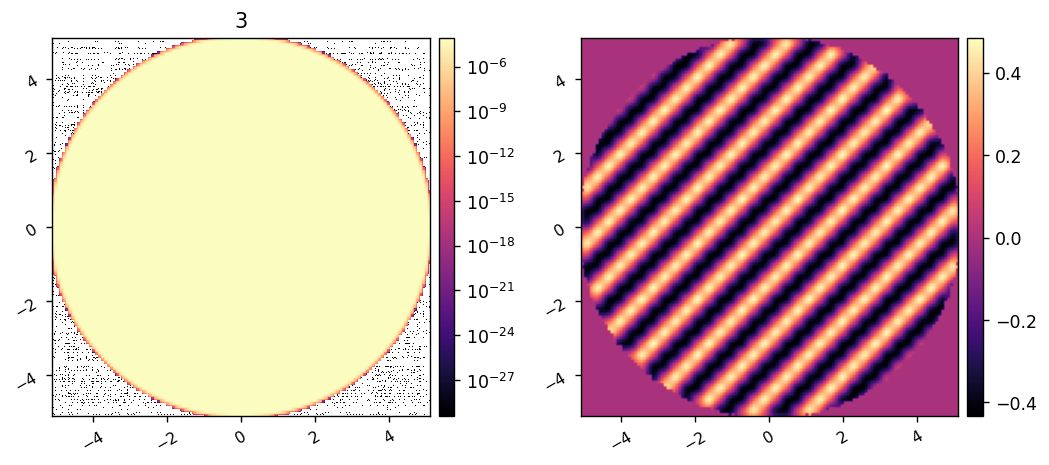

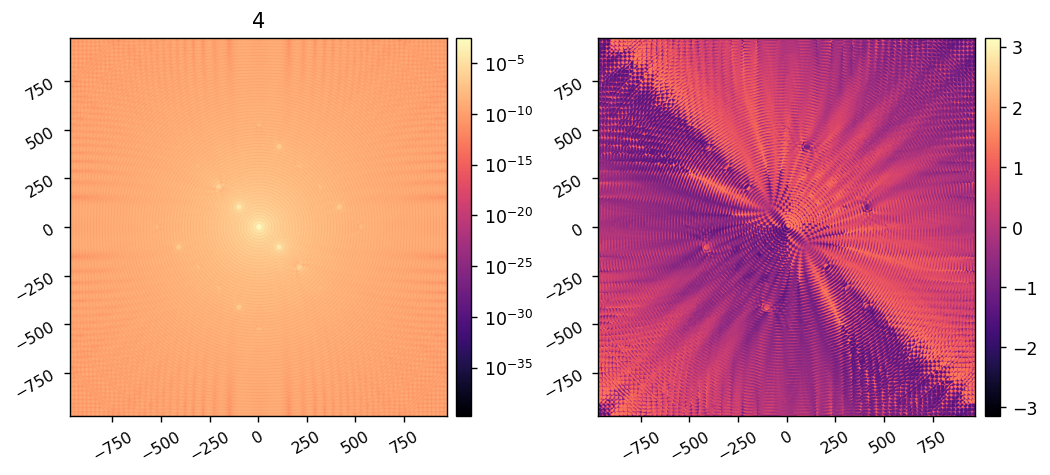

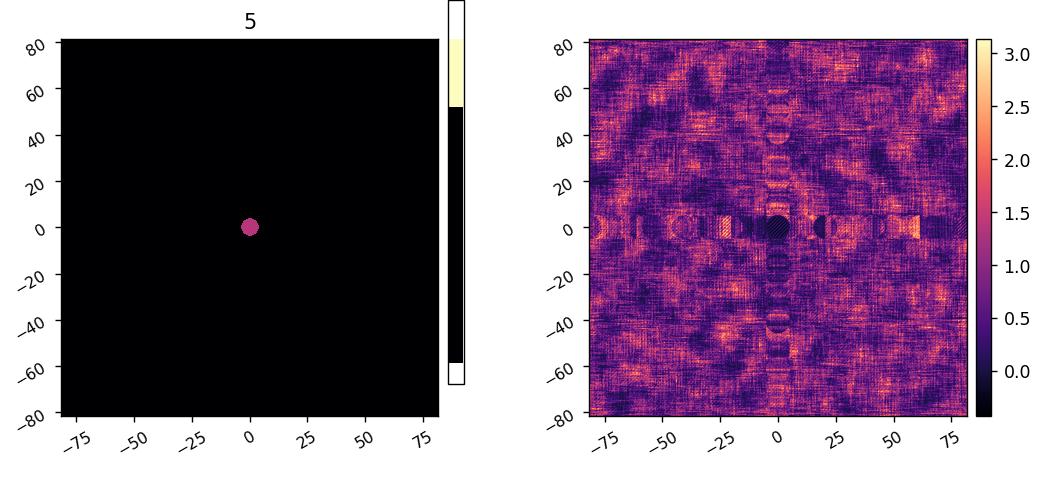

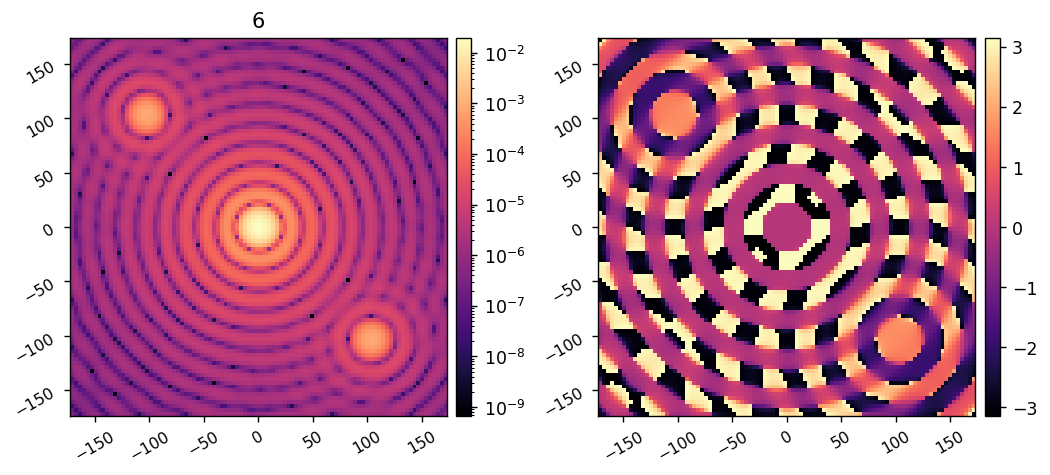

In [46]:
pupil_lim = c.pupil_diam.value/2
fp_lim = 1/2

for i,wf in enumerate(wfs):
#     if i in [c.inter_fp_index, c.fpm_index, c.image_index]:
#         axlims= [-fp_lim, fp_lim, -fp_lim, fp_lim]
#     else:
#         axlims= [-pupil_lim, pupil_lim, -pupil_lim, pupil_lim]
    if wf.planetype is PlaneType.image:
        misc.imshow2(wf.intensity, wf.phase, '{:d}'.format(i), 
                     pxscl1=wf.pixelscale, pxscl2=wf.pixelscale,
    #                  axlims=axlims,
                     lognorm1=True,)
    else:
        misc.imshow2(wf.intensity, wf.phase, '{:d}'.format(i), 
                     pxscl1=wf.pixelscale.to(u.mm/u.pix), pxscl2=wf.pixelscale.to(u.mm/u.pix),
    #                  axlims=axlims,
                     lognorm1=True,)